# Analyse de l'influence des distributions des temps inter-véhiculaire sur un axe routier

Paramètres de simulation:
- 1 voie
- longueur de la voie : 15900 m
- présence d'outils de contrôle de la circulation : non
- paramètres de distribution 
    <br/> dn -> N(8.33, 1) [m]
    <br/> longueur -> N(7, 1) [m]
    <br/> vitesse -> N(14, 3) [m.s^-1]
    <br/> t -> N(2, 0.5) [s]
- durée de la simulation : 500 s = 5000 1/10s   
- seed pour reproductibilité : 45

import des librairies:

In [1]:
import sys
sys.path.append('/Users/lionel/Documents/Cours Polytechnique Montréal/Maitrise/github/projetmaitrise/modules') 
import numpy as np  
import network, simulation 
import makesimulation 
import matplotlib.pyplot as plt
import analysis
import statistics

OpenCV library could not be loaded (video replay functions will not be available)


Récupération des fichiers initiaux

In [2]:
world = network.World.load('inputData/simple-net.yml')  
sim = simulation.Simulation.load('inputData/config.yml')

tracé des trajectoires selon les différentes valeurs des distribution pour les headway

- headways -> Exp(2.1, 1)
</br> On décalle la distribution à 1s % les headways produits ne seront pas inférieurs à cette valeur

In [3]:
# modification des paramètres dans simple-net.yml
world.userInputs[0].distributions['headway'].scale, world.userInputs[0].distributions['headway'].loc = 2.1, 1

# running the simulation
world = makesimulation.run(world, sim)

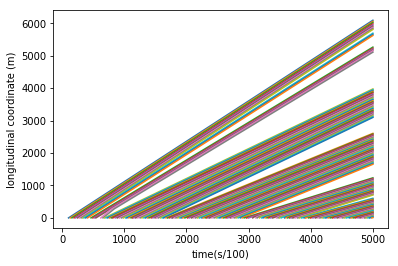

In [4]:
#tracé
plt.figure()
for ui in world.userInputs:
    for v in ui.alignment.vehicles:
        if v.timeInterval is not None:
            v.plotCurvilinearPositions()
    plt.xlabel('time(s/100)')
    plt.ylabel('longitudinal coordinate (m)')
    plt.show()

<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

In [29]:
print(100*len(world.getNotNoneVehiclesInWorld()[0])/len(world.users))
print(len(world.getNotNoneVehiclesInWorld()[0]))

93.25153374233129
152


Distribution des headways observés

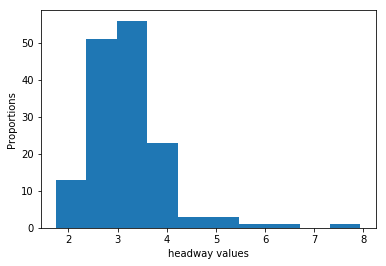

3.230924211655086


In [6]:
h = analysis.getHeadwayValues(world)
analysis.hist(h, 'headway values', 'Proportions')
print(statistics.mean(h))

Distribution des min des distances inter-véhiculaires, pour une coexistence d'une durée minimale de 2 min = 1200 1/10s

In [7]:
d = analysis.getMinDistanceBetweenEachPairCF(world, 1200)

(array([0.00359172, 0.02873377, 0.05387582, 0.08620131, 0.05387582,
        0.0502841 , 0.03950894, 0.04669238, 0.02514205, 0.01436689,
        0.00718344, 0.00359172, 0.00359172, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00359172]),
 array([13.67782165, 16.05746293, 18.43710422, 20.81674551, 23.1963868 ,
        25.57602808, 27.95566937, 30.33531066, 32.71495194, 35.09459323,
        37.47423452, 39.8538758 , 42.23351709, 44.61315838, 46.99279966,
        49.37244095, 51.75208224, 54.13172352, 56.51136481, 58.8910061 ,
        61.27064738, 63.65028867, 66.02992996]),
 <a list of 22 Patch objects>)

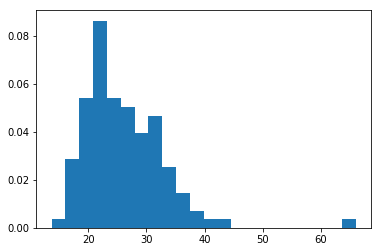

In [8]:
plt.hist(d, bins=22, density=True)# 'min distance between users', 'proportions')

Nombre d'interactions et leur durée observées à une distance < 25 m

In [22]:
interDuration = world.getInteractionsDuration(dmin=25, inLine=True)

In [24]:
c = 0 # nombre d'interaction
s = 0 # duree moyenne des interactions
interactionLength = []
for pair in interDuration:
    if interDuration[pair][0] !=0:
        c += interDuration[pair][0]
        s += sum(interDuration[pair][1:])
        interactionLength.append(interDuration[pair][1:])
print(c, s)

94 170917


duree moyenne des interactions

In [25]:
if c != 0:
    print(s/c)

1818.2659574468084


distribution de la durée des interactions (ayant lieu a une distance < 25 m)
</br>**a voir**

([array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.        , 0.        , 0.00070208]),
  array([0.  

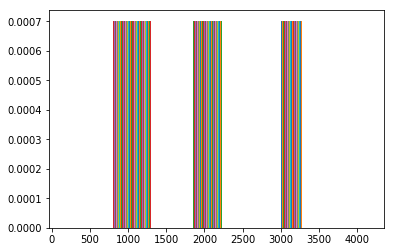

In [28]:
plt.hist(interactionLength, bins=3, density=True)

Tracé des courbes de TTC
**code a venir**

Distribution des TTC min

- headways -> N(x2, y2).
<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

In [ ]:
# modification des paramètres dans simple-net.yml
world = network.World.load('inputData/simple-net.yml')  
world.getUserInputById(0).distributions['headways'].loc, world.getUserInputById(0).distributions['headways'].scale = x1, y1
world = makesimulation.run(world, sim)

In [ ]:
# tracé
plt.figure()
for al in world.alignments:
    for v in al.vehicles:
        if v.timeInterval is not None:
            v.plotCurvilinearPositions()
    plt.xlabel('time(s/100)')
    plt.ylabel('longitudinal coordinate (m)')
    plt.show()

Distribution des headways observés

Distribution des min des distances inter-véhiculaires 

Nombre d'interactions en lignes observées

Temps moyen d'interactions

Tracé des courbes de TTC

Distribution des TTC min

- headways -> N(x3, y3)
<br/> Nombre de véhicules simulés/Nombre de véhicules générés : 

In [ ]:
# modification des paramètres dans simple-net.yml
world = network.World.load('inputData/simple-net.yml')  
world.getUserInputById(0).distributions['headways'].loc, world.getUserInputById(0).distributions['headways'].scale = x1, y1
world = makesimulation.run(world, sim)

In [ ]:
# tracé
plt.figure()
for al in world.alignments:
    for v in al.vehicles:
        if v.timeInterval is not None:
            v.plotCurvilinearPositions()
    plt.xlabel('time(s/100)')
    plt.ylabel('longitudinal coordinate (m)')
    plt.show()

Distribution des headways observés

Distribution des min des distances inter-véhiculaires 

Nombre d'interactions en lignes observées

Temps moyen d'interactions

Tracé des courbes de TTC

Distribution des TTC min